**Student Name   : Srinivas Rengarajan <br>

Electricity Price Forecasting in Irish Energy Market**

**Libraries imported and used in this Project:**<br><br>
***pandas,numpy, matplotlib, seaborn*** - For loading the data into dataframes, preprocessing, analysing and visualising them,<br><br>
***scipy*** - For using advanced scientific functions,<br><br>
***statsmodels*** - For conducting variety of statisticial tests in  analysing time series data,<br><br>
***keras*** - For training and evaluating deep Long Short-Term Memory recurrent neural networks

In [263]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(rc={'figure.figsize':(10,8)})
sns.set(font_scale=1.5)
from datetime import datetime
from scipy import stats
from statsmodels.tsa.stattools import adfuller, grangercausalitytests, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima

import math

import warnings
warnings.filterwarnings('ignore')

#For printing the values without calling print() function everytime
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
# !pip install pmdarima

In [2]:
def importData():
    
    #Read the data from excel file into a dataframe 
    energy_price_df=pd.read_excel("Combined_Energy_Price_Data.xlsx", sheet_name="Sheet5", index_col=0, parse_dates=True)
    energy_price_df.index=pd.date_range(start=datetime(2018,10,2),end=datetime(2020,6,22),freq='H')
    energy_price_df.drop(['Natural Gas Futures Price (Pounds)', 'Rotterdam Coal Futures Price (USD)', 'USD_EU', 'EU_GBP'], axis=1, inplace=True)
    energy_price_df.rename(columns={"Day-ahead Price [EUR/MWh]":"Day_Ahead_Price","Wind Onshore  - Forecast [MW]":"Wind_Forecast",
                               "Total Load Forecast [MW] - BZN|IE(SEM)":"Load_Forecast",
                                "Coal Price [Euro]":"Coal_Price_Euro",
                                "Gas Price [Euro]":"Natural_Gas_Price_Euro","Carbon Price (Euro)":"Carbon_Price_Euro"},inplace=True)
    return energy_price_df

energy_price_df=importData()

#Dataset preview
energy_price_df.head()

,Day_Ahead_Price,Wind_Forecast,Load_Forecast,Carbon_Price_Euro,Coal_Price_Euro,Natural_Gas_Price_Euro
2018-10-02 00:00:00,63.89,2313.0,3745.0,20.95,87.543253,83.374722
2018-10-02 01:00:00,62.00,2382.0,3422.5,20.95,87.543253,83.374722
2018-10-02 02:00:00,56.94,2291.0,3175.5,20.95,87.543253,83.374722
2018-10-02 03:00:00,49.32,2279.0,3055.5,20.95,87.543253,83.374722
2018-10-02 04:00:00,46.30,2210.0,2993.5,20.95,87.543253,83.374722


In [3]:
energy_price_df.index

DatetimeIndex(['2018-10-02 00:00:00', '2018-10-02 01:00:00',
               '2018-10-02 02:00:00', '2018-10-02 03:00:00',
               '2018-10-02 04:00:00', '2018-10-02 05:00:00',
               '2018-10-02 06:00:00', '2018-10-02 07:00:00',
               '2018-10-02 08:00:00', '2018-10-02 09:00:00',
               ...
               '2020-06-21 15:00:00', '2020-06-21 16:00:00',
               '2020-06-21 17:00:00', '2020-06-21 18:00:00',
               '2020-06-21 19:00:00', '2020-06-21 20:00:00',
               '2020-06-21 21:00:00', '2020-06-21 22:00:00',
               '2020-06-21 23:00:00', '2020-06-22 00:00:00'],
              dtype='datetime64[ns]', length=15097, freq='H')

In [4]:
energy_price_df.tail()

,Day_Ahead_Price,Wind_Forecast,Load_Forecast,Carbon_Price_Euro,Coal_Price_Euro,Natural_Gas_Price_Euro
2020-06-21 20:00:00,23.76,2206.0,4436.0,NaN,NaN,NaN
2020-06-21 21:00:00,27.76,1989.0,4506.5,NaN,NaN,NaN
2020-06-21 22:00:00,33.00,1732.0,4344.0,NaN,NaN,NaN
2020-06-21 23:00:00,40.02,1451.0,4157.0,NaN,NaN,NaN
2020-06-22 00:00:00,42.22,1188.0,3960.0,NaN,NaN,NaN


**Dataset Information**

In [5]:
energy_price_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15097 entries, 2018-10-02 00:00:00 to 2020-06-22 00:00:00
Freq: H
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Day_Ahead_Price         15070 non-null  float64
 1   Wind_Forecast           15095 non-null  float64
 2   Load_Forecast           14975 non-null  float64
 3   Carbon_Price_Euro       10535 non-null  float64
 4   Coal_Price_Euro         10631 non-null  float64
 5   Natural_Gas_Price_Euro  10415 non-null  float64
dtypes: float64(6)
memory usage: 825.6 KB


In [6]:
def getMissingValues(df):
    
    print(df.isna().sum())

getMissingValues(energy_price_df)

Day_Ahead_Price             27
Wind_Forecast                2
Load_Forecast              122
Carbon_Price_Euro         4562
Coal_Price_Euro           4466
Natural_Gas_Price_Euro    4682
dtype: int64


Missing Value Details:

Load Forecast - 5 days (122 hours) (less than 1% missing)
Wind Onshore Forecast - 2 hours (1 hour each in Mar 29th and March 31st respectively in 2019 and 2020)
Day-Ahead Price - 1 day and 3 hours (27 hours) 

Natural Gas Price - 195 days (Weekends, State holidays)
Rotterdam Coal Price - 186 days
Carbon Price - 190 days

In [7]:
pd.options.display.float_format = '{:.3f}'.format

1) It is observed that the average day ahead price for the period between October 2018 and June 2020 is about 48 EUR and the maximum price is about 365 EUR. This happens within the electricity market as it is highly volatile, effect of supply and demand and due to socio-political factors.<br><br>
2) The median day ahead electricity price is 45 EUR while the median wind output and load forecast per hour is around 1250 MW/h and 4580 MW/h respecitvely.

In [109]:
energy_price_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Day_Ahead_Price,15097.000,48.186,26.286,-41.090,33.520,44.900,60.520,365.040
Wind_Forecast,15097.000,1517.080,1124.218,31.000,549.000,1252.000,2306.000,4698.000
Load_Forecast,15097.000,4473.612,897.281,2611.500,3683.000,4571.500,5152.000,6715.000
Carbon_Price_Euro,15097.000,23.420,2.903,15.240,21.330,24.090,25.360,29.750
Coal_Price_Euro,15097.000,55.209,13.720,34.663,45.434,51.184,64.429,88.271
Natural_Gas_Price_Euro,15097.000,42.337,19.167,9.275,30.119,38.778,49.990,85.786
WeekDay,15097.000,3.005,1.998,0.000,1.000,3.000,5.000,6.000
WeekInMonth,15097.000,2.681,1.263,1.000,2.000,3.000,4.000,5.000
Month,15097.000,6.307,3.653,1.000,3.000,6.000,10.000,12.000
HourOfDay,15097.000,11.499,6.923,0.000,5.000,11.000,17.000,23.000


Text(0.5,0,'Day_Ahead_Price [EUR/MWh]')

Text(0.5,1,'Distribution of Day_Ahead_Price')

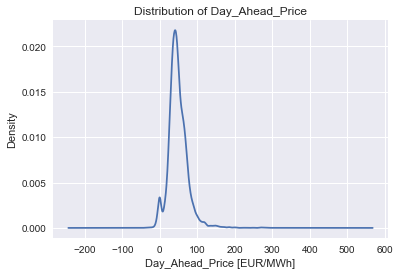

In [9]:
ax=energy_price_df['Day_Ahead_Price'].plot.kde()
ax.set_xlabel("Day_Ahead_Price [EUR/MWh]")
ax.set_title("Distribution of Day_Ahead_Price")

1) The day ahead electricity price distribution is almost normal and so stationary as it has a bell shaped curve with a little bit of longer tail to the right or right skew. We will evaluate this with further analysis.

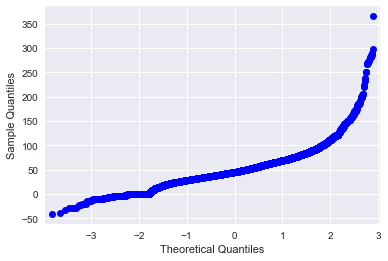

In [10]:
qqplot(energy_price_df['Day_Ahead_Price'], line='s');

In [11]:
cols=['Natural_Gas_Price_Euro','Coal_Price_Euro', 'Carbon_Price_Euro']
stat_cols=['Day_Ahead_Price','Wind_Forecast','Load_Forecast','Natural_Gas_Price_Euro','Coal_Price_Euro', 'Carbon_Price_Euro']

1) On holidays, natural gas, coal and carbon are traded with closing day price on the previous day.Due to this strategy, forward filling mechanism is applied to fill the missing values in these variables. For other variables, since we have less percentage of missing values, linear interpolation is used to impute the missing values.

In [12]:
fossil_fuel_columns = ['Natural_Gas_Price_Euro','Coal_Price_Euro', 'Carbon_Price_Euro']

def fillMissingValues(energy_price_df,columns,isRenewable):
    
    if(isRenewable==False):
        energy_price_df.loc[:,columns] = energy_price_df.loc[:,columns].ffill(axis = 0)
    else:
        energy_price_df.loc[:,columns] = energy_price_df.loc[:,columns].interpolate(method='linear')

fillMissingValues(energy_price_df,fossil_fuel_columns,False)

In [13]:
renewable_columns=['Day_Ahead_Price','Wind_Forecast','Load_Forecast']
fillMissingValues(energy_price_df,renewable_columns,True)

In [14]:
getMissingValues(energy_price_df)

Day_Ahead_Price           0
Wind_Forecast             0
Load_Forecast             0
Carbon_Price_Euro         0
Coal_Price_Euro           0
Natural_Gas_Price_Euro    0
dtype: int64


In [130]:
def visualizeTimeSeries(energy_price_df):
    
    fig, axes = plt.subplots(nrows=2, ncols=3)

    energy_price_df['Day_Ahead_Price'].plot(ax=axes[0][0], linewidth=0.5)
    energy_price_df['Wind_Forecast'].plot(ax=axes[0][1], linewidth=0.5)
    energy_price_df['Load_Forecast'].plot(ax=axes[0][2],linewidth=1.5)
    energy_price_df['Natural_Gas_Price_Euro'].plot(ax=axes[1][0],linewidth=1.5)
    energy_price_df['Coal_Price_Euro'].plot(ax=axes[1][1],linewidth=1.5)
    energy_price_df['Carbon_Price_Euro'].plot(ax=axes[1][2],linewidth=1.5)

    axes[0][0].set_ylabel("Day Ahead Price [EUR/MWh]")
    axes[0][0].set_title("Historical Day Ahead Price")
    axes[0][1].set_ylabel("Wind Power Output Forecast [MW/h]")
    axes[0][1].set_title("Historical Wind Power Output Forecast")
    axes[0][2].set_ylabel("Load Forecast [MW/h]")
    axes[0][2].set_title("Historical Load Forecast")
    axes[1][0].set_ylabel("Natural Gas Price (Euro)")
    axes[1][0].set_title("Historical Natural Gas Price")
    axes[1][1].set_ylabel("Coal Price (Euro)")
    axes[1][1].set_title("Historical Coal Price")
    axes[1][2].set_ylabel("Carbon Price (Euro)")
    axes[1][2].set_title("Historical Carbon Price")

    fig.tight_layout()

# visualizeTimeSeries(energy_price_df)

In [229]:
def plotData(column, xlabel, ylabel, title, linewidth):
    
    ax1=energy_price_df[column].plot(linewidth=linewidth)
    ax1.set_ylabel(ylabel, size=15)
    ax1.set_xlabel(xlabel, size=15)
    ax1.set_title(title, size=15)
    ax1.grid(b=True, which='major', color='#666666', linestyle='-')
    ax1.minorticks_on()
    ax1.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    ax1.set_axis_bgcolor('w')

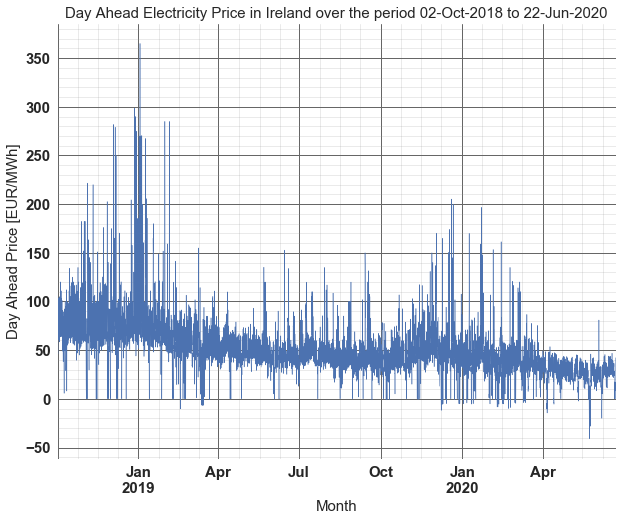

In [264]:
plotData("Day_Ahead_Price","Month","Day Ahead Price [EUR/MWh]","Day Ahead Electricity Price in Ireland over the period 02-Oct-2018 to 22-Jun-2020",0.5)

1) The day ahead electricity price is fluctuating throughout the year. This is due to the fact that electricity price is highly volatile and influenced by various factors. The highest day ahead price in hourly period is around 365 EUR accounting to the fact that there were significant number of unplanned outages across the country.<br>

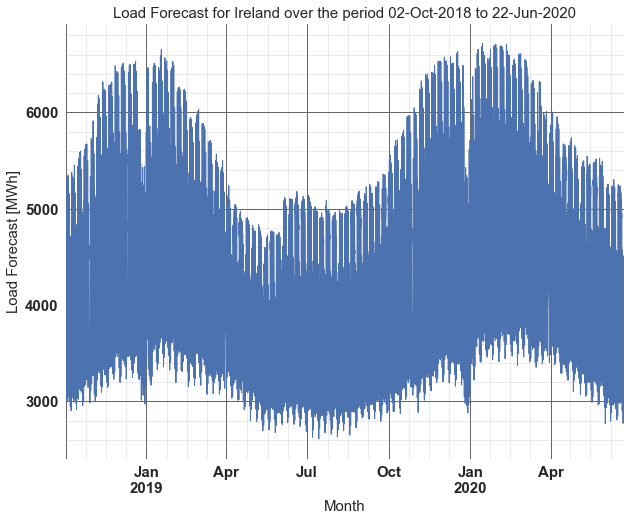

In [265]:
plotData("Load_Forecast","Month","Load Forecast [MWh]","Load Forecast for Ireland over the period 02-Oct-2018 to 22-Jun-2020",1)

1) Seasonality is clearly observed on load (demand) forecast with the winter months requiring huge load potentially due to extensive heater usage whereas the summer months requiring less load or demand.<br>

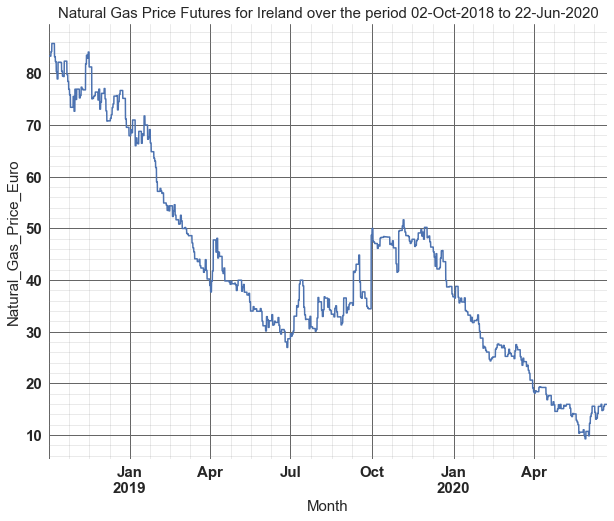

In [266]:
plotData("Natural_Gas_Price_Euro","Month","Natural_Gas_Price_Euro","Natural Gas Price Futures for Ireland over the period 02-Oct-2018 to 22-Jun-2020",1.5)

1) A clear downward trend is observed in the price of fossil fuels, particularly natural gas and coal. This is due to the fact that even though natural gas being the largest source of electricity generated in Ireland, accounting for above 50% in 2018, the amount of electricity generated through various forms of renewables keeps increasing year after year which leads to the decrease in natural gas price. Another insight from the natural gas plot is that even though a slight increase in gas price is observed in the late 2019, after that the uncertainity of the coronavirus (COVID-19) exerted downward pressure on demand and prices.

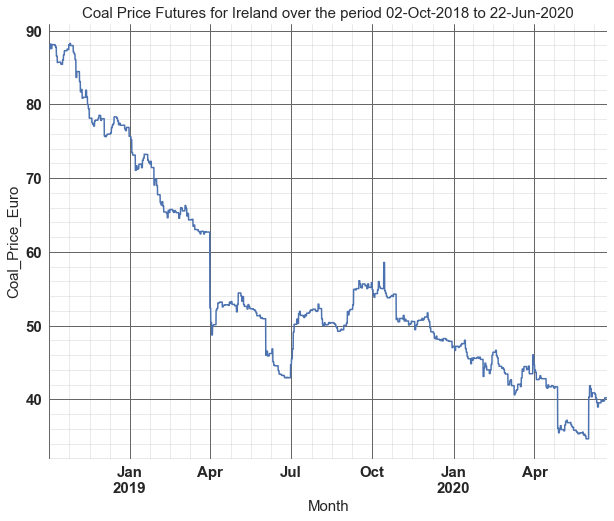

In [267]:
plotData("Coal_Price_Euro","Month","Coal_Price_Euro","Coal Price Futures for Ireland over the period 02-Oct-2018 to 22-Jun-2020",1.5)

In [20]:
energy_price_df['WeekDay']=energy_price_df.index.weekday
energy_price_df['WeekInMonth'] = pd.to_numeric(energy_price_df.index.day/7)
energy_price_df['WeekInMonth'] = energy_price_df['WeekInMonth'].apply(lambda x: math.ceil(x))
energy_price_df['Month']=energy_price_df.index.month
energy_price_df['HourOfDay']=energy_price_df.index.hour
energy_price_df['Year']=energy_price_df.index.year

In [21]:
energy_price_df_month_grouped = energy_price_df.groupby('Month').agg({"Day_Ahead_Price": "mean"})['Day_Ahead_Price']
energy_price_df_weekday_grouped = energy_price_df.groupby('WeekDay').agg({"Day_Ahead_Price": "mean"})['Day_Ahead_Price']
energy_price_df_hour_grouped = energy_price_df.groupby('HourOfDay').agg({"Day_Ahead_Price": "mean"})['Day_Ahead_Price']

Text(0,0.5,'Day Ahead Price [EUR/MWh]')

Text(0.5,0,'Hour')

Text(0,0.5,'Load_Forecast [MW/h]')

Text(0.5,1,'Hourly Average Day-Ahead Price and Hourly Average Load Forecast')

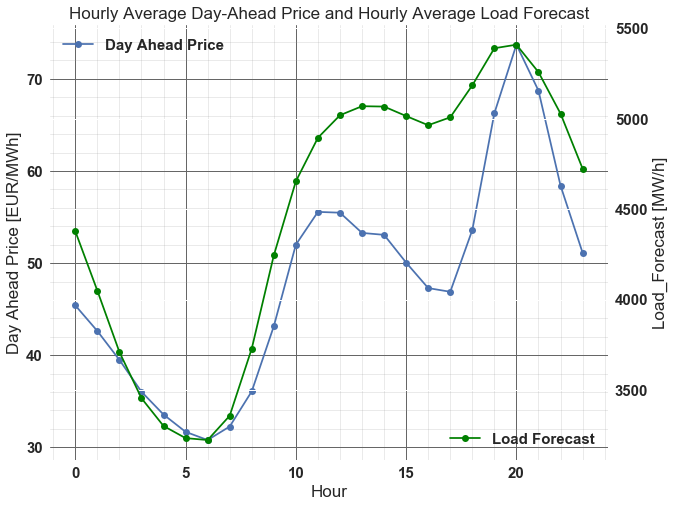

In [271]:
# fig, axes = plt.subplots(nrows=1, ncols=2)
# energy_price_df.groupby('HourOfDay').agg({"Day_Ahead_Price": "mean"})['Day_Ahead_Price'].plot(ax=axes[0],marker='o',linestyle='-')
# energy_price_df.groupby('HourOfDay').agg({"Load_Forecast":"mean"})["Load_Forecast"].plot(color='green',ax=axes[1],marker='o',linestyle='-')
# axes[0].set_ylabel("Day-Ahead Price [EUR/MWh]")
# axes[0].set_title("Hourly Average Day-Ahead Price")
# axes[1].set_ylabel("Load_Forecast [MW/h]")
# axes[1].set_title("Hourly Average Load Forecast")
# fig.suptitle("Hourly Average Day-Ahead Price vs Hourly Average Load Forecast")

ax = energy_price_df.groupby('HourOfDay').agg({"Day_Ahead_Price": "mean"})['Day_Ahead_Price'].plot(marker='o',linestyle='-', label="Day Ahead Price")
ax2 = energy_price_df.groupby('HourOfDay').agg({"Load_Forecast":"mean"})["Load_Forecast"].plot(color='green', secondary_y=True, ax=ax,marker='o',linestyle='-', label="Load Forecast")
ax.set_ylabel('Day Ahead Price [EUR/MWh]', size=17)
ax.set_xlabel("Hour",size=17)
ax.legend(loc=0)
ax2.set_ylabel('Load_Forecast [MW/h]',size=17)
ax2.legend(loc=4)
ax.set_title("Hourly Average Day-Ahead Price and Hourly Average Load Forecast", size=17)
ax.grid(b=True, which='major', color='#666666', linestyle='-')
ax.minorticks_on()
ax.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
ax.set_axis_bgcolor('w')

1) There is a clearly visible relationship between the hourly day ahead price and hourly load (demand) forecast. The day ahead price drops when the load forecast drops and the price peaks when the load (demand) forecast peaks.

Text(0,0.5,'Day-Ahead Price [EUR/MWh]')

Text(0.5,1,'Year-wise Hourly Day-Ahead Price')

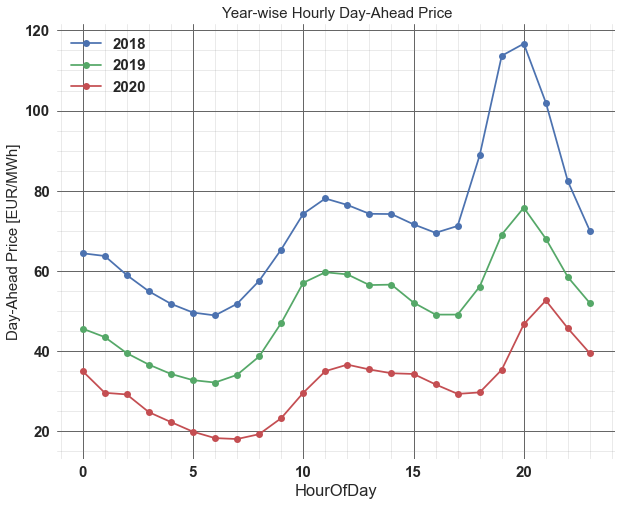

In [272]:
axis=energy_price_df[energy_price_df['Year']==2018].groupby('HourOfDay').agg({"Day_Ahead_Price": "mean"})['Day_Ahead_Price'].plot(marker='o',linestyle='-')
axis=energy_price_df[energy_price_df['Year']==2019].groupby('HourOfDay').agg({"Day_Ahead_Price": "mean"})['Day_Ahead_Price'].plot(ax=axis,marker='o',linestyle='-')
axis=energy_price_df[energy_price_df['Year']==2020].groupby('HourOfDay').agg({"Day_Ahead_Price": "mean"})['Day_Ahead_Price'].plot(ax=axis,marker='o',linestyle='-')

axis.legend(['2018','2019','2020'], loc="top")
axis.set_ylabel("Day-Ahead Price [EUR/MWh]",size=15)
axis.set_title("Year-wise Hourly Day-Ahead Price",size=15)
axis.grid(b=True, which='major', color='#666666', linestyle='-')
axis.minorticks_on()
axis.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
axis.set_axis_bgcolor('w')

1) The electricity price starts dropping in early hours of the day and is the lowest at 6 AM due to the minimum usage of appliances while the price is the highest at 8 PM due to heavy usage. The price is more or less stable during the working hours of the day.<br><br>
2) There is a significant drop in the day ahead electricity prices in the past 2 years.


Text(0,0.5,'Load_Forecast [MW]')

Text(0.5,1,'Year-wise Hourly Load Forecast')

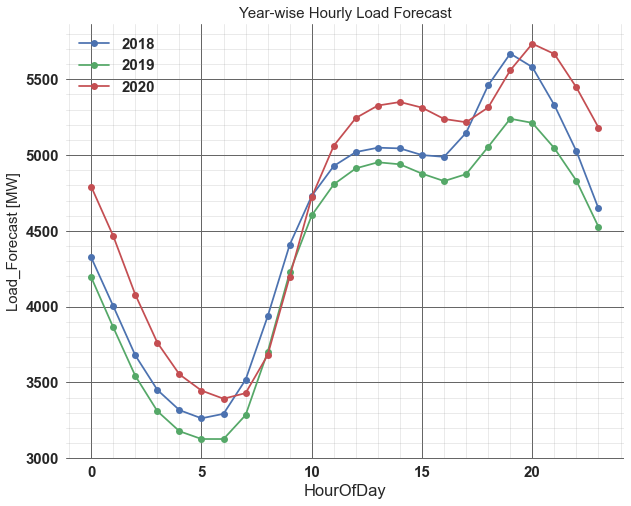

In [273]:
ax=energy_price_df[energy_price_df['Year']==2018].groupby('HourOfDay').agg({"Load_Forecast": "mean"})['Load_Forecast'].plot(marker='o',linestyle='-')
ax=energy_price_df[energy_price_df['Year']==2019].groupby('HourOfDay').agg({"Load_Forecast": "mean"})['Load_Forecast'].plot(ax=ax,marker='o',linestyle='-')
ax=energy_price_df[energy_price_df['Year']==2020].groupby('HourOfDay').agg({"Load_Forecast": "mean"})['Load_Forecast'].plot(ax=ax,marker='o',linestyle='-')

ax.legend(['2018','2019','2020'], loc="left")
ax.set_ylabel("Load_Forecast [MW]",size=15)
ax.set_title("Year-wise Hourly Load Forecast",size=15)
ax.grid(b=True, which='major', color='#666666', linestyle='-')
ax.minorticks_on()
ax.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
ax.set_axis_bgcolor('w')

1) The electricity load is observed to be minimal in the early hours of the day with the lowest at 6 AM, rising through the pre-working hours, attaining the maximum demand around evening 8 PM.<br><br>
2) The first half of 2020 has started with a significant increase in the electricity load forecast with the maximum load being around 5750 MW.

Text(0,0.5,'Load_Forecast [MW]')

Text(0.5,1,'Year-wise Weekly Load Forecast')

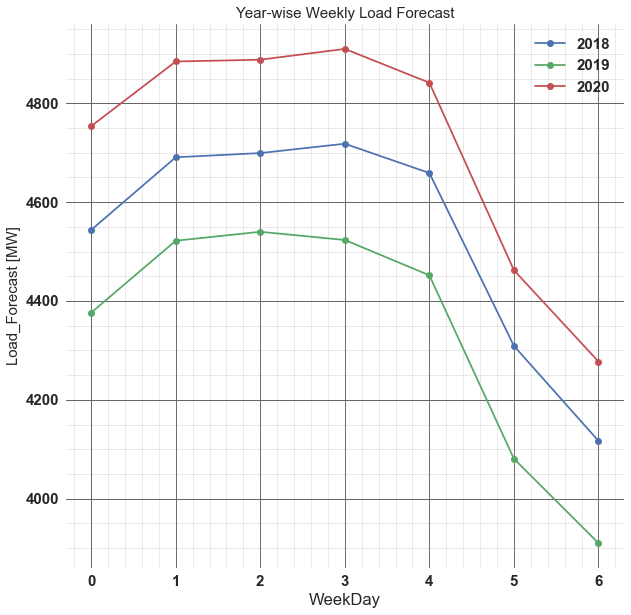

In [239]:
ax=energy_price_df[energy_price_df['Year']==2018].groupby('WeekDay').agg({"Load_Forecast": "mean"})['Load_Forecast'].plot(marker='o',linestyle='-')
ax=energy_price_df[energy_price_df['Year']==2019].groupby('WeekDay').agg({"Load_Forecast": "mean"})['Load_Forecast'].plot(ax=ax,marker='o',linestyle='-')
ax=energy_price_df[energy_price_df['Year']==2020].groupby('WeekDay').agg({"Load_Forecast": "mean"})['Load_Forecast'].plot(ax=ax,marker='o',linestyle='-')

ax.legend(['2018','2019','2020'], loc="top")
ax.set_ylabel("Load_Forecast [MW]",size=15)
ax.set_title("Year-wise Weekly Load Forecast",size=15)
ax.grid(b=True, which='major', color='#666666', linestyle='-')
ax.minorticks_on()
ax.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
ax.set_axis_bgcolor('w')

1) The electricity demand drops during the weekends and remains stable across the week days.

Text(0,0.5,'Day Ahead Price [EUR/MWh]')

Text(0.5,0,'Month')

Text(0,0.5,'Natural_Gas_Price_Euro')

Text(0.5,1,'Monthly Average Day-Ahead Price and Monthly Average Natural Gas Price')

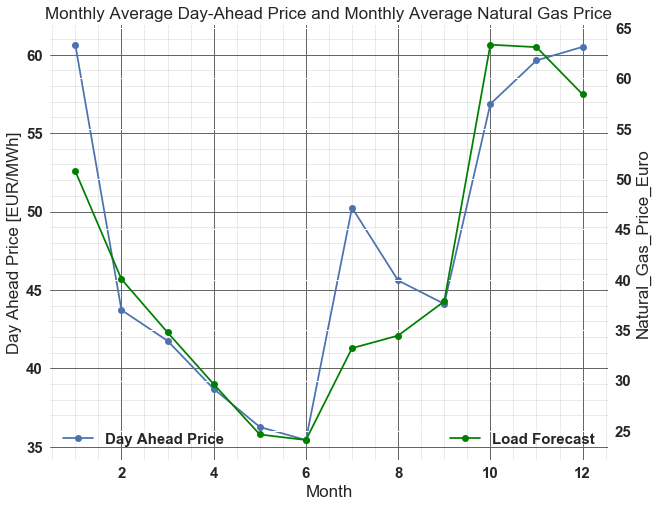

In [275]:
# fig, axes = plt.subplots(nrows=1, ncols=2)
# energy_price_df.groupby('Month').agg({"Day_Ahead_Price": "mean"})['Day_Ahead_Price'].plot(ax=axes[0],marker='o',linestyle='-')
# energy_price_df.groupby('Month').agg({"Natural_Gas_Price_Euro":"mean"})["Natural_Gas_Price_Euro"].plot(color='green',ax=axes[1],marker='o',linestyle='-')
# axes[0].set_ylabel("Day-Ahead Price [EUR/MWh]")
# axes[0].set_title("Monthly Average Day-Ahead Price")
# axes[1].set_ylabel("Natural_Gas_Price_Euro")
# axes[1].set_title("Monthly Average Natural Gas Price")
# fig.suptitle("Monthly Average Day-Ahead Price vs Monthly Average Natural Gas Price")

ax = energy_price_df.groupby('Month').agg({"Day_Ahead_Price": "mean"})['Day_Ahead_Price'].plot(marker='o',linestyle='-', label="Day Ahead Price")
ax2 = energy_price_df.groupby('Month').agg({"Natural_Gas_Price_Euro":"mean"})["Natural_Gas_Price_Euro"].plot(color='green', secondary_y=True, ax=ax,marker='o',linestyle='-', label="Load Forecast")
ax.set_ylabel('Day Ahead Price [EUR/MWh]', size=17)
ax.set_xlabel("Month",size=17)
ax.legend(loc=0)
ax2.set_ylabel('Natural_Gas_Price_Euro',size=17)
ax2.legend(loc=4)
ax.set_title("Monthly Average Day-Ahead Price and Monthly Average Natural Gas Price", size=17)
ax.grid(b=True, which='major', color='#666666', linestyle='-')
ax.minorticks_on()
ax.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
ax.set_axis_bgcolor('w')

1) It can be observed from the above visualization that natural gas price has a significant role in determining the day ahead price due to the fact that both natural gas price and the electricity price is dropping during the first half of the year and increasing during the second half of the year.

In [2]:
# ax=energy_price_df[energy_price_df['Year']==2018].groupby('Month').agg({"Natural_Gas_Price_Euro": "mean"})['Natural_Gas_Price_Euro'].plot(marker='o',linestyle='-')
# ax=energy_price_df[energy_price_df['Year']==2019].groupby('Month').agg({"Natural_Gas_Price_Euro": "mean"})['Natural_Gas_Price_Euro'].plot(ax=ax,marker='o',linestyle='-')
# ax=energy_price_df[energy_price_df['Year']==2020].groupby('Month').agg({"Natural_Gas_Price_Euro": "mean"})['Natural_Gas_Price_Euro'].plot(ax=ax,marker='o',linestyle='-')

# ax.legend(['2018','2019','2020'], loc="center")
# ax.set_ylabel("Natural_Gas_Price_Euro")
# ax.set_title("Year-wise Monthly Natural Gas Price")

1) It is evident that there is a significant decrease in natural gas price in the past 2 years and it drops to its lowest around the summer season in Ireland for around past 2 years. As the amount of electricity generated from wind increases in the last few years according to Sustainable Energy Authority of Ireland (SEAI), it could be observed exerting a downward pressure on natural gas price.   

Text(0,0.5,'Wind Power Output Forecast [MW/h]')

Text(0.5,1,'Year-wise Monthly Wind Forecast')

Text(0,0.5,'Day Ahead Price [EUR/MWh]')

Text(0.5,0,'Day')

Text(0,0.5,'Wind Power Output Forecast [MW/h]')

Text(0.5,1,'Day-Ahead Price and Wind Power Output Forecast')

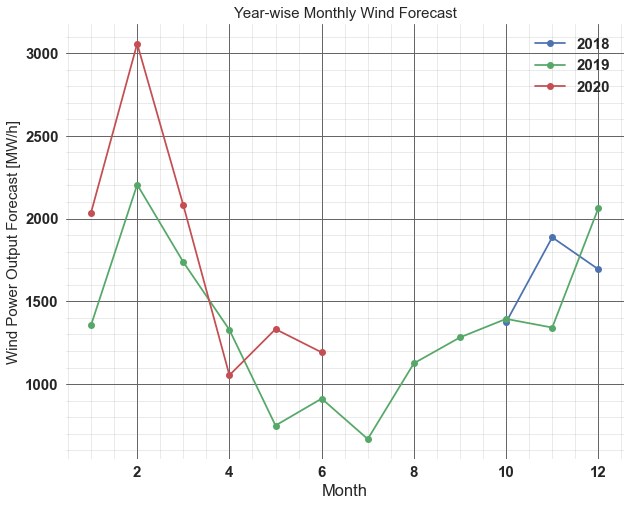

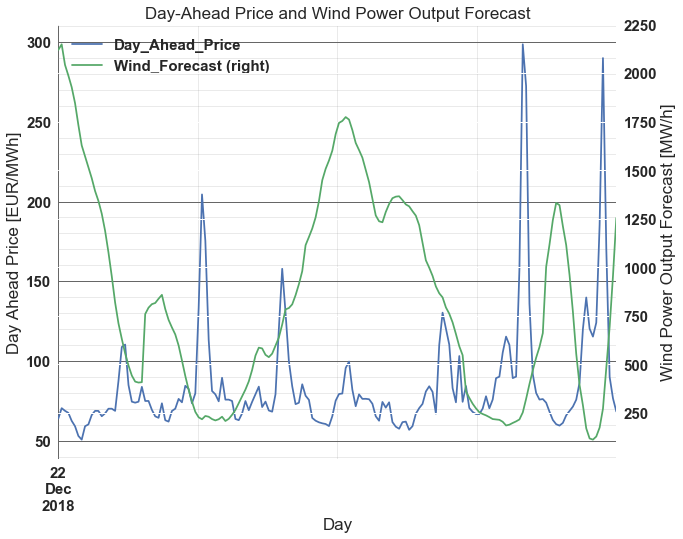

In [274]:
ax=energy_price_df[energy_price_df['Year']==2018].groupby('Month').agg({"Wind_Forecast": "mean"})['Wind_Forecast'].plot(marker='o',linestyle='-')
ax=energy_price_df[energy_price_df['Year']==2019].groupby('Month').agg({"Wind_Forecast": "mean"})['Wind_Forecast'].plot(ax=ax,marker='o',linestyle='-')
ax=energy_price_df[energy_price_df['Year']==2020].groupby('Month').agg({"Wind_Forecast": "mean"})['Wind_Forecast'].plot(ax=ax,marker='o',linestyle='-')

ax.legend(['2018','2019','2020'], loc="top")
ax.set_ylabel("Wind Power Output Forecast [MW/h]",size=15)
ax.set_title("Year-wise Monthly Wind Forecast",size=15)
ax.grid(b=True, which='major', color='#666666', linestyle='-')
ax.minorticks_on()
ax.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
ax.set_axis_bgcolor('w')

ax = energy_price_df[(energy_price_df['Year']==2018) & (energy_price_df['Month']==12) & (energy_price_df['WeekInMonth']==4)].loc[:,['Day_Ahead_Price']].plot()
ax2 = energy_price_df[(energy_price_df['Year']==2018) & (energy_price_df['Month']==12) & (energy_price_df['WeekInMonth']==4)].loc[:,['Wind_Forecast']].plot(secondary_y=True,ax=ax)

ax.set_ylabel('Day Ahead Price [EUR/MWh]',size=17)
ax.set_xlabel("Day",size=17)
ax2.set_ylabel('Wind Power Output Forecast [MW/h]',size=17)
ax.set_title("Day-Ahead Price and Wind Power Output Forecast",size=17)
ax.grid(b=True, which='major', color='#666666', linestyle='-')
ax.minorticks_on()
ax.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
ax.set_axis_bgcolor('w')

1) The forecast of electricity generated through wind energy is maximum during the month of February which is the end of the winter season in Ireland and it is minimum during the month of July which is in the middle of the summer season, potentially due to the warmer temperatures and less wind. <br><br>
2) Wind energy output plays a significant role in forecasting the day ahead price. From the above graph, it could be observed that whenever the wind energy output is forecasted to be high, the day ahead price is determined to be low and vice versa. <br><br>
2) The wind energy output forecast depicts there was a high contribution from wind in Februrary 2020 generating around 3000 MW accounting for 50% of the electricity generation leading to a sharp drop in day ahead electricity prices from above 60 EUR/MWh to around 43 EUR/MWh.  

In [ ]:
# fig, axes = plt.subplots(nrows=1, ncols=2)
# energy_price_df.groupby('Month').agg({"Day_Ahead_Price": "mean"})['Day_Ahead_Price'].plot(ax=axes[0],marker='o',linestyle='-')
# energy_price_df.groupby('Month').agg({"Coal_Price_Euro":"mean"})["Coal_Price_Euro"].plot(color='green',ax=axes[1],marker='o',linestyle='-')
# axes[0].set_ylabel("Day-Ahead Price [EUR/Mwh]")
# axes[1].set_ylabel("Coal_Price_Euro")

**Seasonality of Day Ahead Price**

Text(0.5,0,'Day')

Text(0,0.5,'Day Ahead Price [EUR/MWh]')

Text(0.5,1,'Day_Ahead_Price Seasonality')

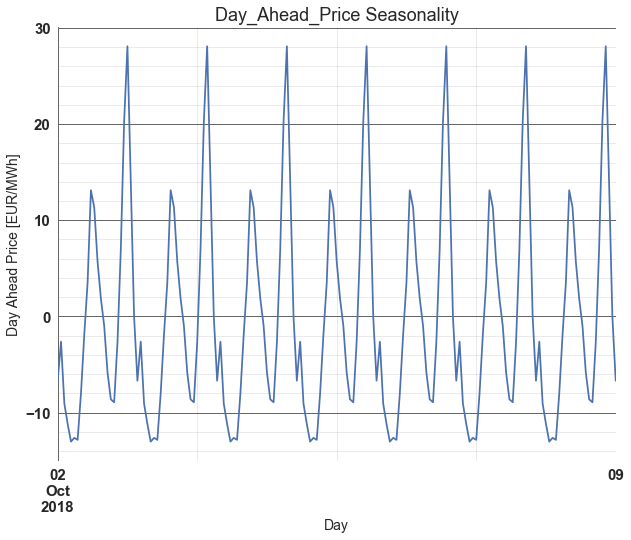

In [282]:
#sns.set(rc={'figure.figsize':(20, 5)})
start_date = datetime(2018,10,2)
end_date = datetime(2018,10,9)
ses=seasonal_decompose(energy_price_df['Day_Ahead_Price'][start_date:end_date],model='additive')
ax=ses.seasonal.plot()
ax.set_xlabel("Day",size=14)
ax.set_ylabel("Day Ahead Price [EUR/MWh]",size=14)
ax.set_title("Day_Ahead_Price Seasonality")
ax.grid(b=True, which='major', color='#666666', linestyle='-')
ax.minorticks_on()
ax.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
ax.set_axis_bgcolor('w')

**Seasonality of Wind Forecast**

In [1]:
# wind_seasonal=seasonal_decompose(energy_price_df['Wind_Forecast'][start_date:end_date],model='additive')
# ax=wind_seasonal.seasonal.plot()
# ax.set_xlabel("Day")
# ax.set_ylabel("Wind Power Output Forecast [MW/h]")
# ax.set_title("Wind Power Output Forecast Seasonality")

**Seasonality of Load Forecast**

In [3]:
# load_seasonal = seasonal_decompose(energy_price_df['Load_Forecast'][start_date:end_date],model='additive')
# ax=load_seasonal.seasonal.plot()
# ax.set_xlabel("Day")
# ax.set_ylabel("Load Forecast [MW/h]")
# ax.set_title("Load Forecast Seasonality")

In [ ]:
# #To visualise the correlation between the variables and the target using correlation matrix heatmap
# def visualiseCorrelation(energy_price_df):
    
#     correlation_matrix=energy_price_df.corr()
#     #Masking the upper triangle
#     uppertrianglemask = np.triu(np.ones_like(correlation_matrix, dtype=np.bool))
#     #Setting up the matplotlib figure
#     f, ax = plt.subplots(figsize=(9, 7))
#     #Customised heatmap
#     sns.heatmap(correlation_matrix, mask=uppertrianglemask, vmin= -.8, vmax=.8, center=0,
#                 square=True, linewidths=.5, cbar_kws={"shrink": .5})

# visualiseCorrelation(energy_price_df.iloc[:,:6])

Text(0.5,1,'Rolling Mean for Day-Ahead-Price')

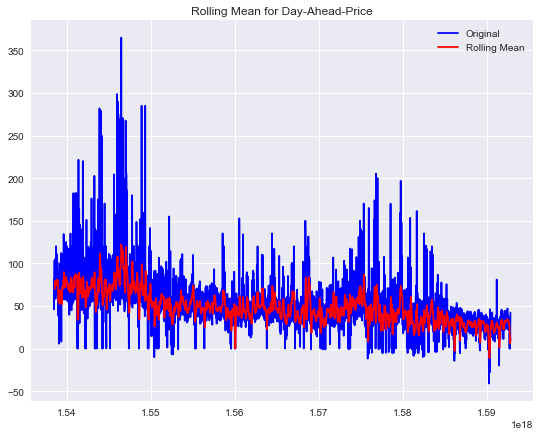

In [31]:
# Plot rolling statistics:
orig = plt.plot(energy_price_df['Day_Ahead_Price'], 
                    color = 'blue', 
                    label = 'Original')
    
rolmean = energy_price_df['Day_Ahead_Price'].rolling(window = 24, center = False).mean()
    
mean = plt.plot(rolmean, 
                    color = 'red', 
                    label = 'Rolling Mean')

plt.legend(loc = 'best')
plt.title('Rolling Mean for Day-Ahead-Price')

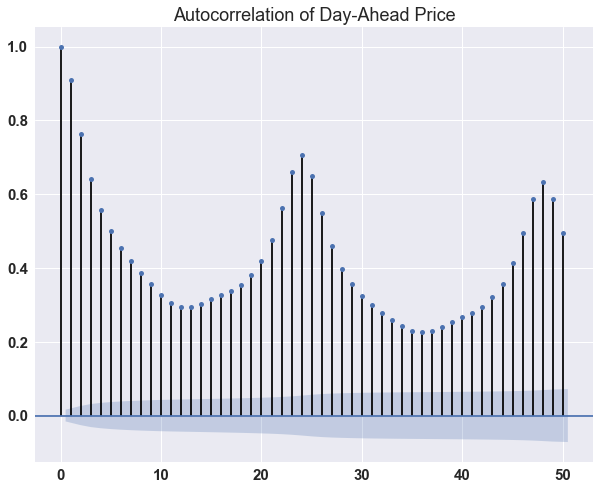

In [286]:
ax=plot_acf(energy_price_df['Day_Ahead_Price'], lags=50, title="Autocorrelation of Day-Ahead Price");
ax.set_label("Lag")
# ax.set_ylabel("Correlation",size=14)

The Autocorrelation plot shows the seasonal structure in the data. As there is seasonality in the data, the autocorrelation plot is larger for the seasonal lags. For every 24 hours, the pattern repeats indicating the daily seasonality.

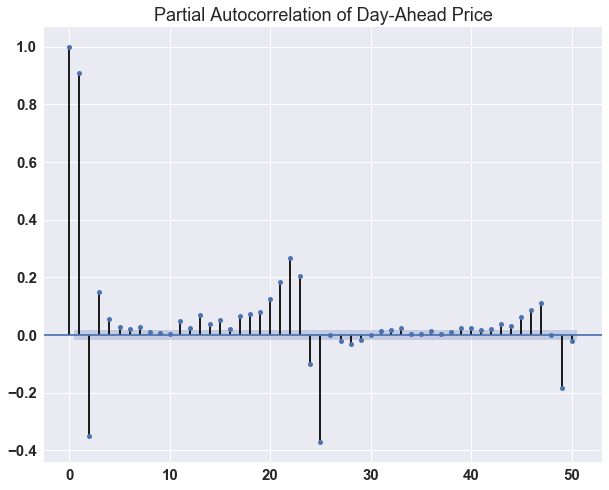

In [287]:
plot_pacf(energy_price_df['Day_Ahead_Price'], lags=50, title="Partial Autocorrelation of Day-Ahead Price");

The Partial Autocorrelation plot also confirms the seasonality effect every 24 hours as the lags at 1,25, 49 are significant.

Text(0.5,1,'Lag Plot of Day_Ahead Price')

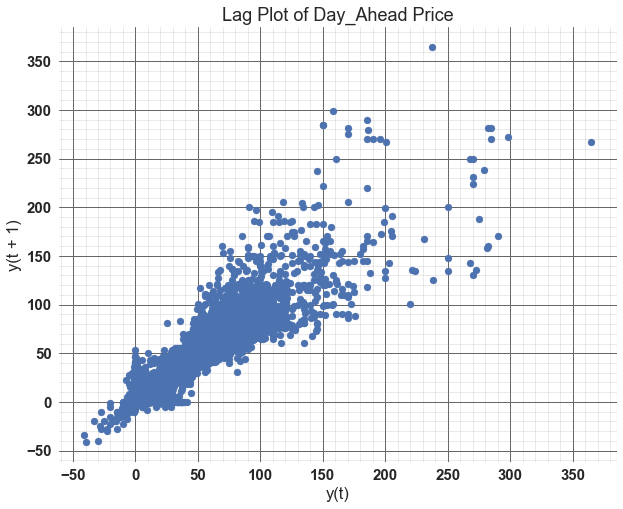

In [308]:
ax=pd.plotting.lag_plot(energy_price_df['Day_Ahead_Price'])
ax.set_title("Lag Plot of Day_Ahead Price")
ax.grid(b=True, which='major', color='#666666', linestyle='-')
ax.minorticks_on()
ax.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
ax.set_axis_bgcolor('w')

1) From the above graph, there exists some strong positive correlation between the lagged values of the day ahead electricity price.

**Augumented Dickey Fuller Test for checking stationarity:***<br><br>

***Null Hypothesis: Unit root is present (non-stationary)***<br>
***Alternate Hypothesis: Unit root is not present (stationary)***<br><br>
ADF test takes into account the trend, constant and error term.<br>

Since the fossil fuel prices have trend component in it, their p-values are greater than 0.05, so we fail to reject the null hypothesis and conclude that we did not have significant evidence to prove unit root is not present and therefore th data is not stationary. 

In [35]:
def performAdfTest(cols,df):
    
    print("Augmented Dickey Fuller Test for Stationarity: \n")
    [print("The t-stat and p-value for", variable,"is :",adfuller(df[variable], autolag='t-stat')[0],"and",adfuller(df[variable], autolag='t-stat')[1]) for variable in cols]

performAdfTest(cols,energy_price_df)

Augmented Dickey Fuller Test for Stationarity: 

The t-stat and p-value for Natural_Gas_Price_Euro is : -1.651796872388712 and 0.45610347166893694
The t-stat and p-value for Coal_Price_Euro is : -2.2690225649211118 and 0.18215348940168014
The t-stat and p-value for Carbon_Price_Euro is : -2.486757541148634 and 0.11872969475445116


In [100]:
print("Augmented Dickey Fuller Test for Stationarity: \n")
print("The t-stat and p-value is :",adfuller(energy_price_df['Day_Ahead_Price'], autolag='t-stat')[0],"and",adfuller(energy_price_df['Day_Ahead_Price'], autolag='t-stat')[1])

Augmented Dickey Fuller Test for Stationarity: 

The t-stat and p-value is : -7.459495654918917 and 5.400877951209311e-11


**Kwiatkowski – Phillips – Schmidt – Shin (KPSS) Test for checking stationarity:***<br><br>

***Null Hypothesis: The series is stationary***<br>
***Alternate Hypothesis: The series is not stationary***<br><br>

Since the day-ahead price has deterministic trend component in it, the p-value is less than 0.05, so we reject the null hypothesis and conclude that we have significant evidence to prove that the data is not stationary. 

In [280]:
statistic, p_value, n_lags, critical_values = kpss(energy_price_df['Day_Ahead_Price'])
print(p_value, statistic, critical_values)

0.01 19.130284881484545 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


**Making the data stationary by Differencing**<br>
Since we have daily seasonality pattern, we difference the data by 24 hour periods, to make it stationary

In [36]:
energy_price_df_stationary=energy_price_df.diff(24)
energy_price_df_stationary=energy_price_df_stationary.dropna()

In [37]:
performAdfTest(stat_cols,energy_price_df_stationary)

Augmented Dickey Fuller Test for Stationarity: 

The t-stat and p-value for Day_Ahead_Price is : -23.434418324158447 and 0.0
The t-stat and p-value for Wind_Forecast is : -23.52028882553386 and 0.0
The t-stat and p-value for Load_Forecast is : -23.93523553253972 and 0.0
The t-stat and p-value for Natural_Gas_Price_Euro is : -17.10538842216223 and 7.428001334373719e-30
The t-stat and p-value for Coal_Price_Euro is : -16.008297744899544 and 6.39759468509688e-29
The t-stat and p-value for Carbon_Price_Euro is : -16.080227752008046 and 5.388381864423767e-29


1) Now the data has become stationary since all the p-values are less than 0.05 (at 5% significance level) which we could use for modelling and forecasting

In [283]:
statistic, p_value, n_lags, critical_values = kpss(energy_price_df_stationary['Day_Ahead_Price'])
print(p_value, statistic, critical_values)

0.1 0.0031319328475079376 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


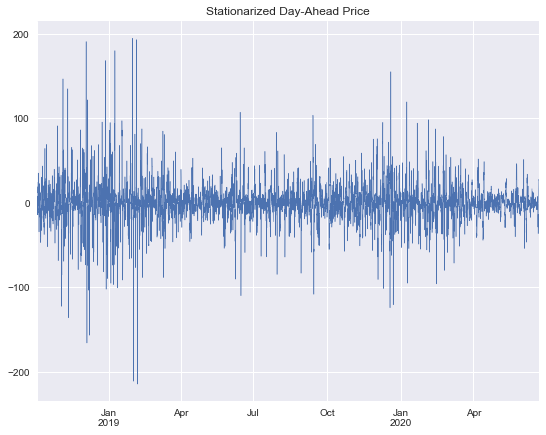

In [38]:
energy_price_df_stationary['Day_Ahead_Price'].plot(linewidth=0.5, title="Stationarized Day-Ahead Price")

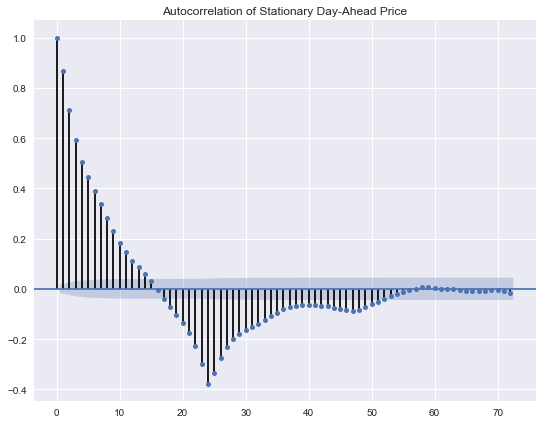

In [39]:
plot_acf(energy_price_df_stationary['Day_Ahead_Price'], lags=72, title="Autocorrelation of Stationary Day-Ahead Price");

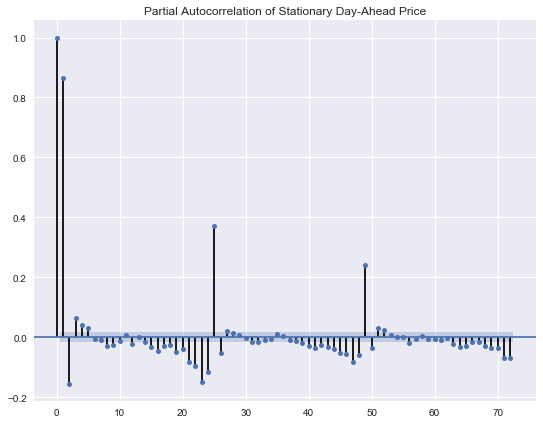

In [40]:
plot_pacf(energy_price_df_stationary['Day_Ahead_Price'], lags=72, title="Partial Autocorrelation of Stationary Day-Ahead Price");

In [88]:
# grangercausalitytests(energy_price_df[['Day_Ahead_Price','Wind_Forecast']], maxlag=7, addconst=True, verbose=False)

**Univariate Time Series Modelling and Forecasting** <br><br>

Error metrics used are MAE (Mean Absolute Error) and RMSE (Root Mean Squared Error). The RMSE penalizes large errors as it is taking the square of the errors. The MAE gives the absolute value of the average error. It is simple and easy to understand but it does not penalizes large errors as RMSE does. So, we consider both of the metrics. Both are helpful in observing or finding the average magnitude of the error. The AIC is less for (1,0,1,(1,1,1,24) and also its RMSE and MAE are lesser comparatively.

In [41]:
# grid search sarima hyperparameters
from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error, mean_absolute_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


In [300]:
# multi-step Holt Winter’s Exponential Smoothing forecast
def exp_smoothing_forecast(history, config):
    t,d,s,p,b,r = config
    # define model
    model = ExponentialSmoothing(history, trend=t, damped=d, seasonal=s, seasonal_periods=p)
    # fit model
    model_fit = model.fit(optimized=True, use_boxcox=b, remove_bias=r)
    # make multi step forecast
    yhat = model_fit.forecast(168)
    return yhat
 

# multi-step sarima forecast
def sarima_forecast(history, config):
    order, sorder = config
    # define model
    model = SARIMAX(history, order=order, seasonal_order=sorder, enforce_stationarity=False, enforce_invertibility=False)
    # fit model
    model_fit = model.fit(disp=False)
    # make multi step forecast
    yhat = model_fit.forecast(168)
    return (yhat,model_fit.aic)

# root mean squared error or rmse
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

#mean absolute error or mae
def measure_mae(actual, predicted):
    return mean_absolute_error(actual, predicted)

# def mean_absolute_percentage_error(y_true, y_pred): 
#     y_true, y_pred = np.array(y_true), np.array(y_pred)
#     return np.mean(np.abs((y_true - y_pred) / y_true+0.1)) * 100

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg, isSarima):
    predictions = list()
    aicList=list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # seed history with training dataset
    history = [x for x in train]
    #weeks 1 and 2
    days=[7,14]
    # step over each time-step in the test set
    for i in days:
        j=(i-7)*24
        if isSarima: 
            # fit SARIMA model and make forecast for history
            (yhat,aic) = sarima_forecast(history, cfg)
            # store forecast in list of predictions
            predictions.extend(yhat)
            aicList.append(aic)
        else:
            # fit Holt Winters Exponential model and make forecast for history
            yhat = exp_smoothing_forecast(history, cfg)
            # store forecast in list of predictions
            predictions.extend(yhat)
            
        # add actual observation to history for the next loop
        history.extend(test[j:i*24])

    # estimate prediction error
    error = measure_rmse(test, predictions)
    return (error,aicList[len(aicList)-1])

# evaluate a model, return None on failure
def evaluate_model(data, n_test, cfg, isSarima, debug=False):
    result = None
    # convert config to a key
    key = str(cfg)
    # show all warnings and fail on exception if debugging
    if debug:
        (result,aic) = walk_forward_validation(data, n_test, cfg, isSarima)
    else:
        # one failure during model validation suggests an unstable config
        try:
            # never show warnings when grid searching, too noisy
            with catch_warnings():
                filterwarnings("ignore")
                (result,aic) = walk_forward_validation(data, n_test, cfg, isSarima)
        except:
            error = None
    # check for an interesting result
    if result is not None and aic is not None:
        print(' > Model[%s] %.3f AIC: %.3f' % (key, result, aic))
    return (key, result, aic)

# grid search configs
def grid_search(data, cfg_list, n_test, isSarima, parallel=False):
    scores = None
    if parallel:
        # execute configs in parallel
        executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
        tasks = (delayed(evaluate_model)(data, n_test, cfg, isSarima) for cfg in cfg_list)
        scores = executor(tasks)
    else:
        scores = [evaluate_model(data, n_test, cfg, isSarima) for cfg in cfg_list]
    # remove empty results
    scores = [r for r in scores if r[1] != None]
    # sort configs by error, asc
    scores.sort(key=lambda tup: tup[1])
    return scores

# create a set of exponential smoothing configs to try
def exp_smoothing_configs(seasonal=[None]):
    models = list()
    # define config lists
    #trend parameters
    t_params = ['add', 'mul', None]
    #dampening parameters
    d_params = [True, False]
    #seasonal parameters
    s_params = ['add', 'mul', None]
    #seasonal period parameters
    p_params = seasonal
    #Box-Cox transformation parameters
    b_params = [True, False]
    #Remove Bias parameters
    r_params = [True, False]
    # create config instances
    for t in t_params:
        for d in d_params:
            for s in s_params:
                for p in p_params:
                    for b in b_params:
                        for r in r_params:
                            cfg = [t,d,s,p,b,r]
                            models.append(cfg)
    return models

# create a set of sarima configs to try
def sarima_configs(seasonal):
    models = list()
    # define config lists
    p_params = [0, 1]
    q_params = [0, 1]
    P_params = [0, 1]
    Q_params = [0, 1]
    m_params = seasonal
    d=[0,1]
    D=1
    # create config instances
    for p in p_params:
            for q in q_params:
                  for P in P_params:
                          for Q in Q_params:
                                for m in m_params:
                                    cfg = [(p,d,q), (P,D,Q,m)]
                                    models.append(cfg)
    return models

In [307]:
data = energy_price_df['Day_Ahead_Price'].values
print(data.shape)
# SARIMA model configs
# cfg_list = sarima_configs(seasonal=[12,24])

models=list()

#From ACF and PACF plots, we observed the AR(1) and MA(1) process (p,q,P and Q values are 1) with 1 seasonal differencing needed
#to remove the seasonality thereby making the data stationary. Therefore testing probable parameters in the above range.
models.append([(0,0,0),(1,1,1,24)])
models.append([(1,0,1),(1,1,1,24)])
models.append([(0,0,0),(2,1,2,24)])
models.append([(2,0,2),(2,1,2,24)])
models.append([(0,0,0),(3,1,3,24)])
models.append([(3,0,3),(3,1,3,24)])

cfg_list=models
n_test=336
# grid search
scores = grid_search(data, cfg_list, n_test, isSarima=True)
print('Top three optimal configurations:')
# list top n configs
for cfg, error, aic in scores[:3]:
    print(cfg, round(error,3), round(aic,3))

The walk forward validation strategy for search of optimal parameters for SARIMA has resulted in the AR(1) and MA(1) process (p,q,P and Q values are 1) with 1 seasonal differencing (D) of 24 hours period as it has lesser AIC (Akaike Information Criterion score).

**Train/Test Split**<br><br>
The dataset is divided into training set for model building and testing set for model evaluation in such a way that the last four weeks data is selected as the test set and the rest being the training set.

In [44]:
#672 hours for 4 weeks (28 days)
train=energy_price_df['Day_Ahead_Price'].iloc[:-672]
test=energy_price_df['Day_Ahead_Price'].iloc[-672:]

In [105]:
len(train)

14425

In [106]:
len(test)

672

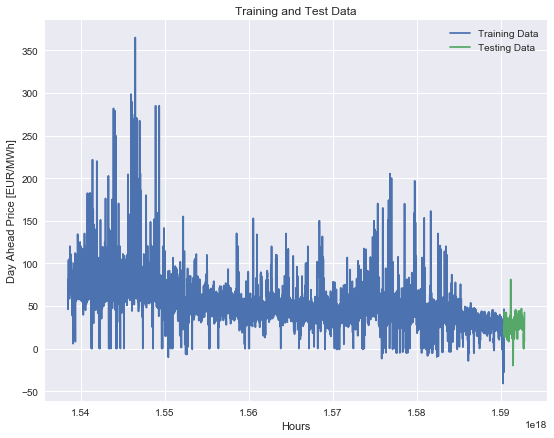

In [45]:
def plot_train_test(train, test, isActual):
    
    plt.plot(train)
    plt.plot(test)
    plt.xticks()
    plt.title("Training and Test Data")
    if isActual:
        plt.legend(['Training Data', 'Testing Data'], loc='best')
    else:
        plt.legend(['Training Data', 'Forecasting Data'], loc='best')
    plt.xlabel("Hours") 
    plt.ylabel("Day Ahead Price [EUR/MWh]")
    plt.show()

plot_train_test(train,test,isActual=True)    

**Univariate Time Series Forecasting using SARIMA (Seasonal AutoRegressive Integrated Moving Average) model**

Since our data has seasonal effects, normal ARIMA model will not account for seasonality, so SARIMA model is used. Seasonal ARIMA determines the day-ahead-price as the linear combination of previous day-ahead prices (Auto Regression (AR)) and its previous errors (Moving Average (MA)) considering seasonal behavior too.

***From ACF, PACF plots and the grid search for optimal parameters, we observed the AR(1) and MA(1) process (p,q,P and Q values are 1) with 1 seasonal differencing (D) of 24 hours period has lesser AIC (Akaike Information Criterion score) and thereby making the data stationary. The number of seasons (m) after which the pattern repeats in the data is 24 as it contains daily seasonality. We are including the lagged values from 24 periods ago, as well as the error term from 24 periods ago***<br><br>

Error metrics used are MAE (Mean Absolute Error) and RMSE (Root Mean Squared Error). Both are helpful in observing or finding the average magnitude of the error. The AIC was less for (1,0,1,(1,1,1,24) and also its RMSE and MAE are lesser comparatively.


In [310]:
def univariateSARIMA(train, test, exog):
    
    exog_train = energy_price_df[['Wind_Forecast','Load_Forecast','Natural_Gas_Price_Euro']].iloc[:-672]
    exog_test = energy_price_df[['Wind_Forecast','Load_Forecast','Natural_Gas_Price_Euro']].iloc[-672:] 
    
    #If exogeneous, including selected exogenious regressors for determining the day-ahead electricity price in Ireland
    if exog:     
        sarima_model = SARIMAX(train, order=(1,0,1), seasonal_order=(1,1,1,24), exog=exog_train, enforce_stationarity=False, enforce_invertibility=False)
    else:  
        sarima_model = SARIMAX(train, order=(1,0,1), seasonal_order=(1,1,1,24), enforce_stationarity=False, enforce_invertibility=False)
    
    # fit model
    sarima_model_fit = sarima_model.fit(disp=False)
    
    #Autocorrelation Plot of Residuals
    plot_acf(sarima_model_fit.resid, lags=72, title="Autocorrelation Plot of SARIMA model Residuals")
    
    if exog:
        # make multi step forecast
        sarima_model_forecast = sarima_model_fit.forecast(672, exog=exog_test)
    else:
        # make multi step forecast
        sarima_model_forecast = sarima_model_fit.forecast(672)
    
    prediction_df = sarima_model_forecast.to_frame()
    prediction_df['Actual'] = test.values
    prediction_df.index = test.index
    
    if exog:  
        prediction_df.rename(columns={0:'SARIMAX Forecast'},inplace=True)
    else:
        prediction_df.rename(columns={0:'SARIMA Forecast'},inplace=True)
    
    print("Root Mean Square Error (RMSE) is:",measure_rmse(test.values, sarima_model_forecast))
    print("Mean Absolute Error (MAE) is:",measure_mae(test.values, sarima_model_forecast),"\n")
    
    if exog:
        print("\nLjung-Box Test for SARIMA model with Exogenous variables fit\n")
    else:
        print("\nLjung-Box Test for SARIMA model fit\n")
        
    #Ljung Box Test for checking model fit
    #Null Hypothesis: The model does not exhibit lack of fit
    #Alternate Hypothesis: The model exhibit lack of fit
    
    residual_corr=acorr_ljungbox(sarima_model_fit.resid, lags=[2], return_df=True)
    print(residual_corr.head())
    
    if exog:
        axy=prediction_df.plot(figsize=(12,8), title='Test Set Actuals vs SARIMAX Forecasts')
        #prediction_df.iloc[287:336].plot(figsize=(12,8))
    else:
        axy=prediction_df.plot(figsize=(12,8), title='Test Set Actuals vs SARIMA Forecasts')   
        
    axy.set_xlabel("Day")
    axy.set_ylabel("Day Ahead Price [EUR/MWh]")
    axy.grid(b=True, which='major', color='#666666', linestyle='-')
    axy.minorticks_on()
    axy.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    axy.set_axis_bgcolor('w')
    
    ax=sarima_model_fit.resid.to_frame().plot.kde()
    ax.set_xlabel("Model Residuals")
    ax.set_title("Distribution of Model Residuals")
    
#     print(sarima_model_fit.summary())
    
    return sarima_model_forecast


Root Mean Square Error (RMSE) is: 11.742337669793786
Mean Absolute Error (MAE) is: 9.837403573070228 


Ljung-Box Test for SARIMA model fit

   lb_stat  lb_pvalue
2    5.633      0.060


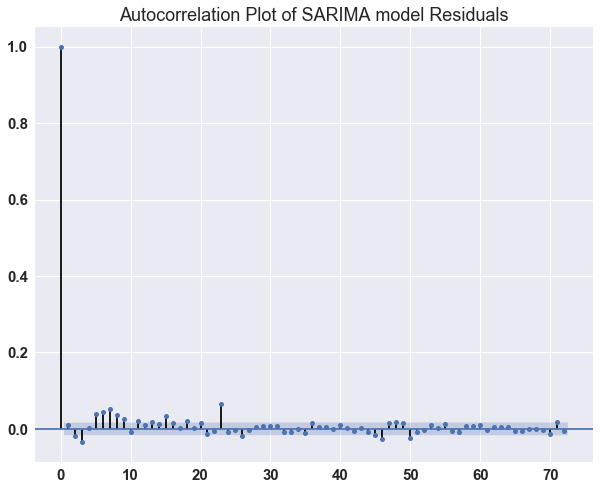

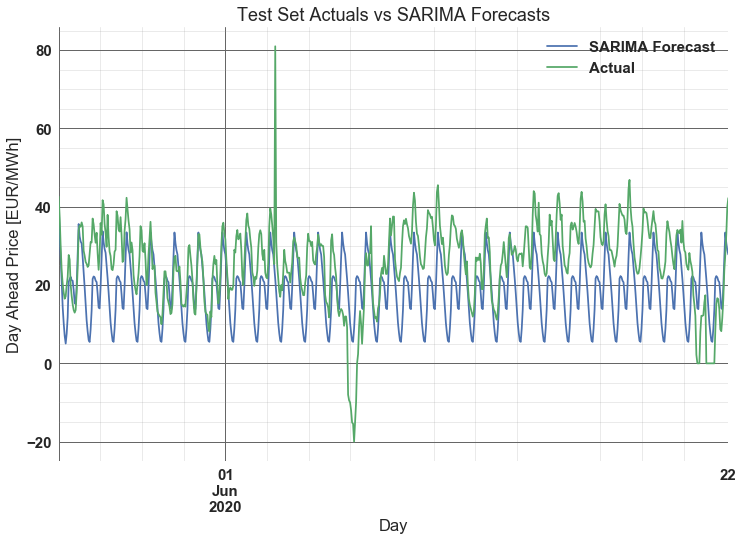

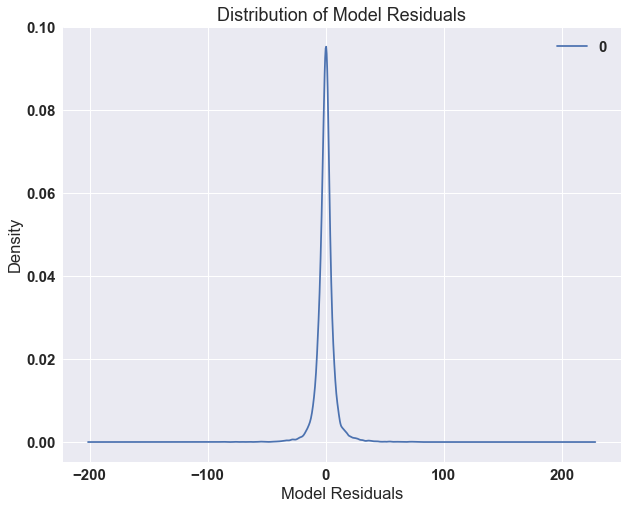

In [311]:
sarima_forecast = univariateSARIMA(train, test, exog=False)

From the above Test set Actuals vs Forecasts plot, we observe that though the SARIMA model accounts for seasonality, it was not able to account for unexpected price changes, and the mean absolute error is around 10 euro. Though the residuals look normally distributed, this error is significantly large for electricty price forecasting problem. We tried to reduce the mae and rmse by training a SARIMAX model. 

In [48]:
sarima_full_model=SARIMAX(energy_price_df['Day_Ahead_Price'], order=(1,0,1), seasonal_order=(1,1,1,24), enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)

Text(0,0.5,'Day Ahead Price [EUR/MWh]')

Text(0.5,1,'Out of Sample Forecast for SARIMA')

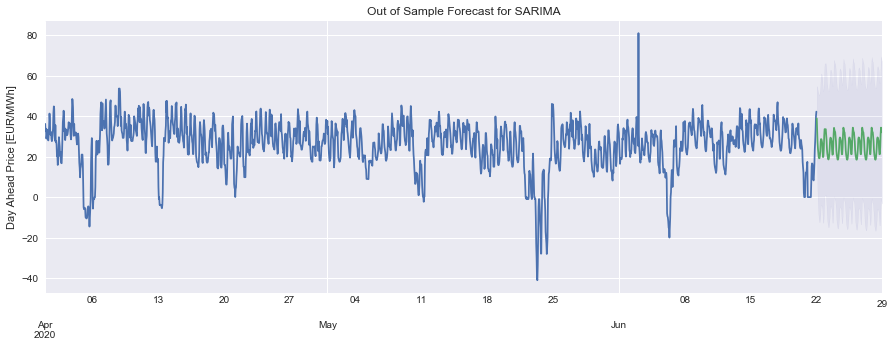

In [49]:
fig,ax=plt.subplots(figsize=(15,5))

energy_price_df['Day_Ahead_Price'].loc['2020-04-01':].plot(ax=ax)

forecast=sarima_full_model.get_forecast(steps=168).summary_frame()
forecast['mean'].plot(ax=ax)
ax.fill_between(forecast.index,forecast['mean_ci_lower'],forecast['mean_ci_upper'], color='darkblue', alpha=0.05)
ax.set_ylabel("Day Ahead Price [EUR/MWh]")
ax.set_title("Out of Sample Forecast for SARIMA")

**Univariate Time Series Forecasting using SARIMAX (Seasonal AutoRegressive Integrated Moving Average with Exogeneous Regressors)**

From the Exploratory Data Analysis done on the data, it is observed that the day ahead electricity price in Ireland is influenced by the wind power output, natural gas price and demand forecast. SARIMAX model calculates the value at current timestep t, as the linear combination of its past values, past errors along with the values of the exogeneous variables at t. So the current day-ahead-price is given by its lagged values, lagged errors and the current wind forecast, demand forecast and natural gas price.

Root Mean Square Error (RMSE) is: 8.259541585680052
Mean Absolute Error (MAE) is: 6.599691049291122 


Ljung-Box Test for SARIMA model with Exogenous variables fit

   lb_stat  lb_pvalue
2    0.180      0.914


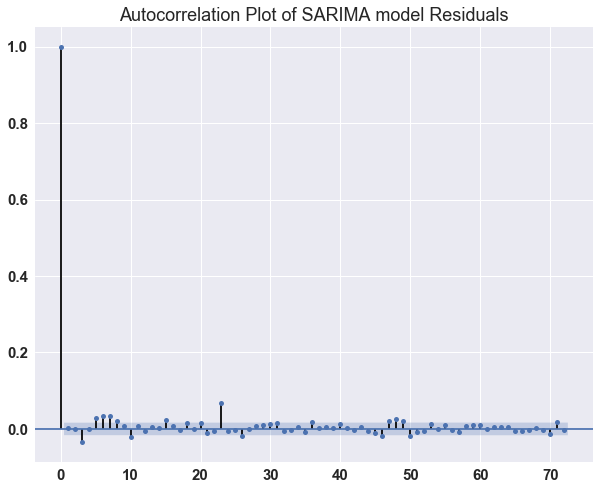

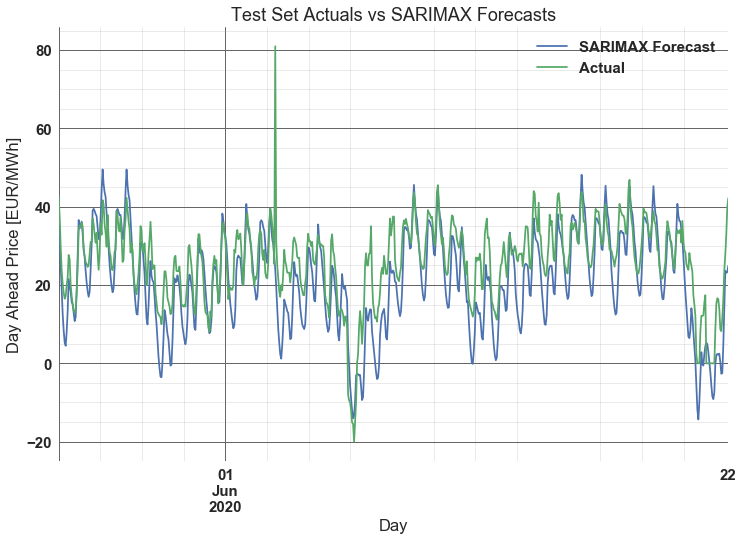

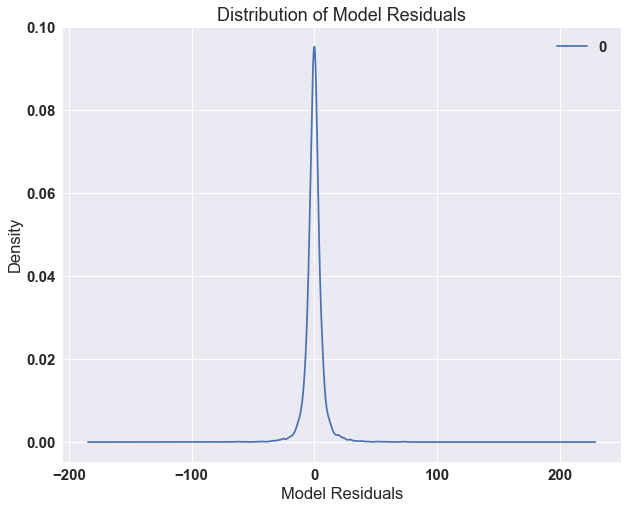

In [312]:
sarimax_forecast = univariateSARIMA(train, test, exog=True)

From the above forecast plot, we observe that the SARIMAX model accounts for seasonal effects in the data and the mean absolute error is around 6.6 euro. The error has been significantly reduced to that of SARIMA model by 3 euro. But as in the previous cases, it was not able to account for unexpected price changes. So, we tried to reduce the mae and rmse further by building a Long-Short- Term Memory Recurrent Neural Network. 

**Statistical Significance Test for comparing the baseline model's performance with SARIMAX model**<br><br>

We perform a paired t-test to check the null hypothesis that the average of the two models' forecasts are identical.

Null Hypothesis: The forecast average for SARIMAX model is identical to that of the baseline model
Alternate Hypothesis: The forecast average for SARIMAX model is not identical to that of the baseline model

In [53]:
tstatistic,p_value = stats.ttest_rel(sarima_forecast,sarimax_forecast)
print("T-Stat: ",tstatistic,"p-value: ", p_value)

T-Stat:  -5.581842985950712 p-value:  3.4566173901091787e-08


The p-value is less than 0.05 (5% significance level), thereby rejecting the null hypothesis to conclude that at 95% confidence interval, the forecast average for SARIMAX model is significantly different to that of the baseline model.

In [ ]:
np.std(energy_price_df['Day_Ahead_Price'])

**Univariate Long-Short-Term Memory (LSTM) Recurrent Neural Network (RNN)**

LSTM Neural Network, like other Recurrent Neural Networks (RNN), differ from a standard feed-forward neural network approach by the use of previous input sources (lookback) within the calculation for predicting the values at the future timesteps.

The LSTM model will learn a function that maps a sequence of past observations (lookback or lags) as input to an output observation. For that, the sequence of observations must be transformed into multiple examples from which the LSTM RNN can learn. LSTM approach solves the gradient error explosion issue by adding the ability of memorizing and updating the new information or deleting them if not necessary to its architecture.

In [317]:
# Convert an array of values into a dataset matrix for walk forward validation strategy
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

def build_lstm_rnn_model(df, ts, look_back, epochs):
    
    # Fix random seed for reproducibility
    np.random.seed(599)

    # Get the dataset
    dataset = df[ts].values
    dataset = dataset.astype('float32')

    # Normalizing the dataset into [0,1] range
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(dataset.reshape(-1, 1))
  
    # Split into train and test sets
#     train_size = int(len(dataset) * train_fraction)
#     test_size = len(dataset) - train_size
#     train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
  
    train, test = dataset[:-672], dataset[-672:]
    
    # Reshaping into X=t and Y=t+1
    look_back = look_back
    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)
  
    # Reshaping input to be [samples, time steps, features]
    trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
    testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))
  
    # Creating and fitting a LSTM network
    lstm_model = Sequential()
    lstm_model.add(LSTM(4, input_shape=(look_back, 1), dropout=0.1))
    lstm_model.add(Dense(1))
    lstm_model.compile(loss='mean_squared_error', optimizer='adam')
    
    #fitting the model
    lstm_model.fit(trainX, trainY, epochs = epochs, batch_size = 1, verbose = 2)
  
    # Making predictions
    trainPredictions = lstm_model.predict(trainX)
    testPredictions = lstm_model.predict(testX)
  
    # Inverting predictions
    trainPredictions = scaler.inverse_transform(trainPredictions)
    trainY = scaler.inverse_transform([trainY])
    testPredictions = scaler.inverse_transform(testPredictions)
    testY = scaler.inverse_transform([testY])
  
    # Calculating root mean squared error
    trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredictions[:,0]))
#     print('Train Score: %.2f RMSE' % (trainScore))
    test_rmse_score = math.sqrt(mean_squared_error(testY[0], testPredictions[:,0]))
    test_mae_score = mean_absolute_error(testY[0], testPredictions[:,0])
    print('Root Mean Square Error (RMSE) is: %.2f' % (test_rmse_score))
    print('Mean Absolute Error (MAE) is: %.2f' % (test_mae_score))
  
    # Shift the train predictions for plotting
    trainPredictionsPlot = np.empty_like(dataset)
    trainPredictionsPlot[:, :] = np.nan
    trainPredictionsPlot[look_back:len(trainPredictions)+look_back, :] = trainPredictions
  
    # Shift the test predictions for plotting
    testPredictionsPlot = np.empty_like(dataset)
    testPredictionsPlot[:, :] = np.nan
    testPredictionsPlot[len(trainPredictions)+(look_back*2)+1:len(dataset)-1, :] = testPredictions
  
    # Plot the original dataset as well as predictions
    plt.plot(scaler.inverse_transform(dataset))
    plt.plot(trainPredictionsPlot)
    plt.plot(testPredictionsPlot)
    plt.legend(['Day_Ahead_Price','Training Set Predictions', 'Testing Set Predictions'], loc='best')
    plt.xlabel("Hours") 
    plt.ylabel("Day Ahead Price [EUR/MWh]")
    plt.title("Original Data vs Predictions")
    plt.show()
    plt.close()
  
    prediction_df = pd.DataFrame(testPredictions)
    prediction_df['Actual'] = testY[0]
    prediction_df.rename(columns={0:'LSTM RNN Forecast'},inplace=True)
    ax=prediction_df.plot(figsize=(12,8), title='Test Set Actuals vs Test Set Forecast - LSTM')
    ax.set_xlabel("Hours")
    ax.set_ylabel("Day Ahead Price [EUR/MWh]")
    ax.grid(b=True, which='major', color='#666666', linestyle='-')
    ax.minorticks_on()
    ax.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    ax.set_axis_bgcolor('w')
    
#   future_df = pd.DataFrame({'Future':lstm_model.predict(15097, 15433)})
#   future_df.plot(figsize=(12,8), title='Future Forecasts for Day-ahead-Price')

    return prediction_df

Epoch 1/5
 - 72s - loss: 0.0023
Epoch 2/5
 - 56s - loss: 0.0013
Epoch 3/5
 - 50s - loss: 0.0011
Epoch 4/5
 - 52s - loss: 0.0011
Epoch 5/5
 - 51s - loss: 9.8070e-04
Root Mean Square Error (RMSE) is: 6.11
Mean Absolute Error (MAE) is: 4.44


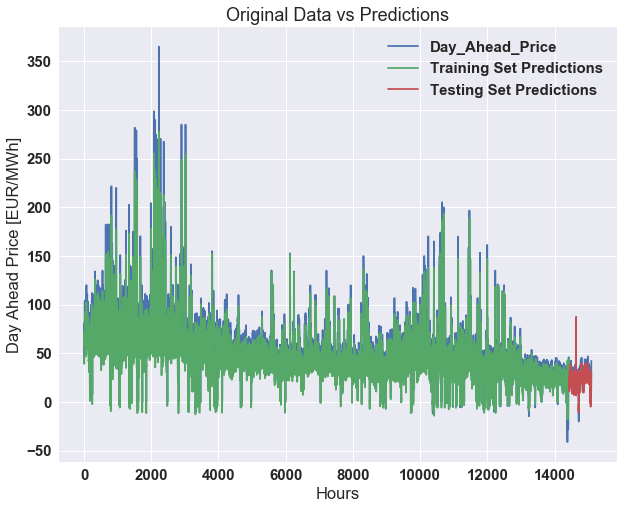

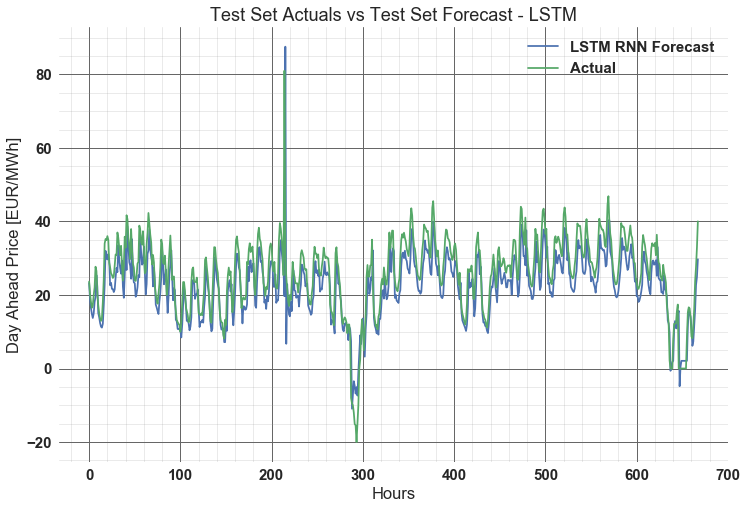

In [318]:
# LSTM RNN
lstm_rnn_model = build_lstm_rnn_model(df = energy_price_df, ts = 'Day_Ahead_Price', look_back = 3, epochs = 5)

From the above forecast plot, we observe that the univariate LSTM-RNN model accounts for seasonal effects in the data, unexpected price peaks and price drops, and the mean absolute error is around 4 euro. The MAE error has been significantly reduced to that of SARIMA model by 4.5 euro and to that of SARIMAX model by 2 euro. The predictions are able to closely track the actual test set values. The test set error evaluation of all these models results that the LSTM RNN model outperforms all the other models by reducing the RMSE and MAE. The model has the capability to memorize the structure of the data. The trade-off in this is the loss of interpretability as neural network is a black box model which possess a complicated structure.

**Multiple Input LSTM RNN Model**

In [56]:
# multivariate data preparation
from numpy import array
from numpy import hstack

In [322]:
# splitting a multivariate sequence into samples
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

# Fix random seed for reproducibility
np.random.seed(599)

# Normalizing the dataset into [0,1] range
scaler = MinMaxScaler(feature_range=(0, 1))

# converting into [rows, columns] structure
out_seq = scaler.fit_transform(energy_price_df['Day_Ahead_Price'].to_numpy().reshape(-1, 1)).reshape((len(energy_price_df['Day_Ahead_Price']), 1))
in_seq_1 = scaler.fit_transform(energy_price_df['Wind_Forecast'].to_numpy().reshape(-1, 1)).reshape((len(energy_price_df['Wind_Forecast']), 1))
in_seq_2 = scaler.fit_transform(energy_price_df['Load_Forecast'].to_numpy().reshape(-1, 1)).reshape((len(energy_price_df['Load_Forecast']), 1))
in_seq_3 = scaler.fit_transform(energy_price_df['Natural_Gas_Price_Euro'].to_numpy().reshape(-1, 1)).reshape((len(energy_price_df['Natural_Gas_Price_Euro']), 1))

# horizontally stack columns
dataset = hstack((in_seq_1, in_seq_2, in_seq_3,out_seq))

# choose a number of time steps
n_steps = 3

# converting into input/output
X, y = split_sequences(dataset, n_steps)
print(X.shape, y.shape)

x_train,y_train=X[:-672],y[:-672]
x_test,y_test=X[-672:],y[-672:]

# summarize the data
# for i in range(len(X)):
#     print(X[i], y[i])
  
# Creating and fitting a LSTM network
lstm_model2 = Sequential()
lstm_model2.add(LSTM(4, input_shape=(n_steps, 3)))
lstm_model2.add(Dense(1))
lstm_model2.compile(loss='mean_squared_error', optimizer='adam')
    
#fitting the model
lstm_model2.fit(x_train, y_train, epochs = 5, batch_size = 1, verbose = 2)

(15095, 3, 3) (15095,)
Epoch 1/5
 - 62s - loss: 0.0020
Epoch 2/5
 - 53s - loss: 0.0015
Epoch 3/5
 - 51s - loss: 0.0015
Epoch 4/5
 - 52s - loss: 0.0014
Epoch 5/5
 - 51s - loss: 0.0014


In [323]:
# Making predictions
# trainPredictions = lstm_model.predict(trainX)
testForecasts = lstm_model2.predict(x_test)
  
# Inverting predictions
# trainPredictions = scaler.inverse_transform(trainPredictions)
# trainY = scaler.inverse_transform([trainY])
testForecasts = scaler.inverse_transform(testForecasts)
y_test = scaler.inverse_transform([y_test])
  
# Calculating root mean squared error
# trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredictions[:,0]))
# print('Train Score: %.2f RMSE' % (trainScore))

test_rmse = math.sqrt(mean_squared_error(y_test[0], testForecasts[:,0]))
test_mae = mean_absolute_error(y_test[0], testForecasts[:,0])
print('Root Mean Square Error (RMSE) is: %.2f' % (test_rmse))
print('Mean Absolute Error (MAE) is: %.2f' % (test_mae))

Root Mean Square Error (RMSE) is: 1.40
Mean Absolute Error (MAE) is: 1.04


Text(0.5,0,'Hours')

Text(0,0.5,'Day Ahead Price [EUR/MWh]')

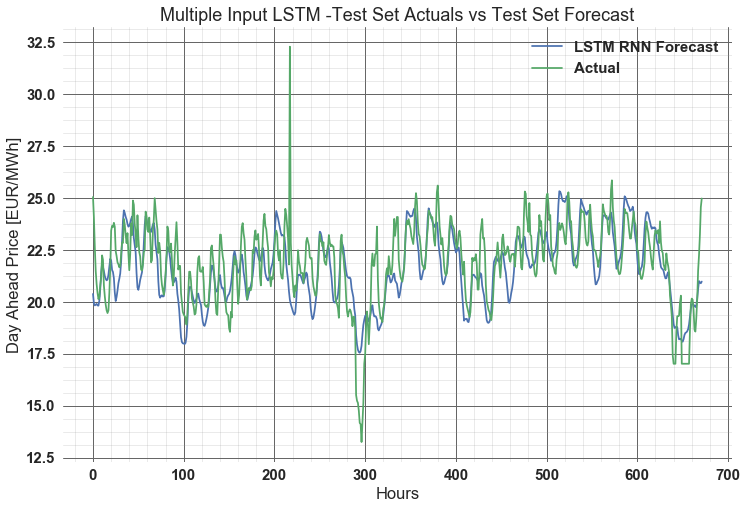

In [325]:
prediction_df_multiple_input_lstm = pd.DataFrame(testForecasts)
prediction_df_multiple_input_lstm['Actual'] = y_test[0]
prediction_df_multiple_input_lstm.rename(columns={0:'LSTM RNN Forecast'},inplace=True)
ax=prediction_df_multiple_input_lstm.plot(figsize=(12,8), title='Multiple Input LSTM -Test Set Actuals vs Test Set Forecast')
ax.set_xlabel("Hours")
ax.set_ylabel("Day Ahead Price [EUR/MWh]")
ax.grid(b=True, which='major', color='#666666', linestyle='-')
ax.minorticks_on()
ax.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
ax.set_axis_bgcolor('w')

In [84]:
lstm_multi_input_test_forecast = pd.Series(testForecasts[:,0], index=test.index)
tStatistic,pValue = stats.ttest_rel(sarima_forecast, lstm_multi_input_test_forecast)
print("T-Stat: ",tStatistic,"p-value: ", pValue)

T-Stat:  -10.121026344220693 p-value:  1.668998306648624e-22
